In [1]:
%matplotlib inline


Simple visualization and classification of the digits dataset
=============================================================

Plot the first few samples of the digits dataset and a 2D representation
built using PCA, then do a simple classification



In [2]:
from sklearn.datasets import load_digits
digits = load_digits()

Plot the data: images of digits
-------------------------------

Each data in a 8x8 image



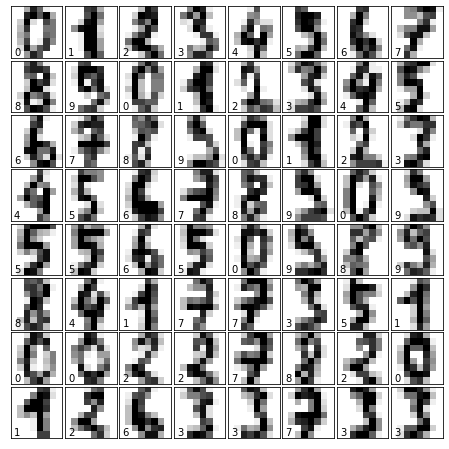

In [3]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

Plot a projection on the 2 first principal axis
------------------------------------------------



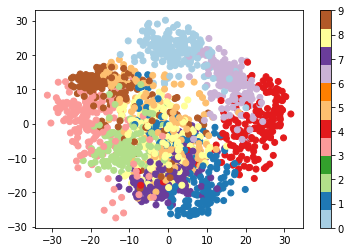

In [4]:
plt.figure()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proj = pca.fit_transform(digits.data)
plt.scatter(proj[:, 0], proj[:, 1], c=digits.target, cmap="Paired")
plt.colorbar()

Classify with Gaussian naive Bayes
----------------------------------



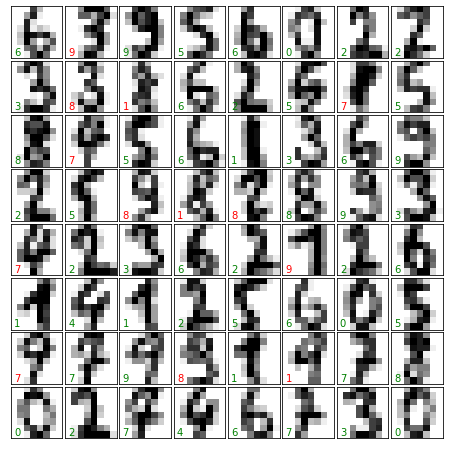

In [5]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

# split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target)

# train the model
clf = GaussianNB()
clf.fit(X_train, y_train)

# use the model to predict the labels of the test data
predicted = clf.predict(X_test)
expected = y_test

# Plot the prediction
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test.reshape(-1, 8, 8)[i], cmap=plt.cm.binary,
              interpolation='nearest')

    # label the image with the target value
    if predicted[i] == expected[i]:
        ax.text(0, 7, str(predicted[i]), color='green')
    else:
        ax.text(0, 7, str(predicted[i]), color='red')

Quantify the performance
------------------------

First print the number of correct matches



In [6]:
matches = (predicted == expected)
print(matches.sum())

371


The total number of data points



In [7]:
print(len(matches))

450


And now, the ration of correct predictions



In [8]:
matches.sum() / float(len(matches))

0.8244444444444444

Print the classification report



In [9]:
from sklearn import metrics
print(metrics.classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       0.67      0.80      0.73        45
           2       0.92      0.67      0.78        52
           3       0.97      0.70      0.81        53
           4       0.91      0.82      0.86        39
           5       0.91      0.97      0.94        40
           6       1.00      1.00      1.00        40
           7       0.69      1.00      0.82        38
           8       0.59      0.85      0.69        52
           9       0.92      0.53      0.68        45

    accuracy                           0.82       450
   macro avg       0.86      0.83      0.83       450
weighted avg       0.86      0.82      0.82       450



Print the confusion matrix



In [10]:
print(metrics.confusion_matrix(expected, predicted))

plt.show()

[[46  0  0  0  0  0  0  0  0  0]
 [ 0 36  1  0  0  0  0  2  5  1]
 [ 0  6 35  0  1  0  0  0 10  0]
 [ 0  2  2 37  0  1  0  4  6  1]
 [ 0  2  0  0 32  0  0  4  1  0]
 [ 0  0  0  0  0 39  0  0  1  0]
 [ 0  0  0  0  0  0 40  0  0  0]
 [ 0  0  0  0  0  0  0 38  0  0]
 [ 0  4  0  1  0  1  0  2 44  0]
 [ 0  4  0  0  2  2  0  5  8 24]]


In [11]:
import struct
from PIL import Image
import numpy as np

def read_record_ETL1G(f):
    s = f.read(2052)
    r = struct.unpack('>H2sH6BI4H4B4x2016s4x', s)
    iF = Image.frombytes('F', (64, 63), r[18], 'bit', 4)
    iL = iF.convert('P')
    return r + (iL,)

def read_kana():
    katakana = np.zeros([51, 1411, 63, 64], dtype=np.uint8) # 51 characters, 1411 writers, img size = 63*64
    for i in range(7,14):
        filename = 'ETL1/ETL1C_{:02d}'.format(i)
        with open(filename, 'rb') as f: # file 13 only has 3 characters, others have 8 characters
            if i!=13: limit = 8
            else: limit=3
            for dataset in range(limit):
                for j in range(1411):
                    try :
                        r = read_record_ETL1G(f)
                        katakana[(i - 7) * 8 + dataset, j] = np.array(r[-1])
                    except struct.error: # two imgs are blank according to the ETL website, so this prevents any errors
                        pass
    np.savez_compressed("kana.npz", katakana)

read_kana()

FileNotFoundError: [Errno 2] No such file or directory: 'ETL1/ETL1C_07'

In [ ]:
import skimage.transform
import numpy as np
from sklearn.model_selection import train_test_split

kana = np.load("kana.npz")['arr_0'].reshape([-1, 63, 64]).astype(np.float32)

kana = kana/np.max(kana) # make the numbers range from 0 to 1

# 51 is the number of different katakana (3 are duplicates so in the end there are 48 classes), 1411 writers.
train_images = np.zeros([51 * 1411, 48, 48], dtype=np.float32)

for i in range(51 * 1411): # change the image size to 48*48
    train_images[i] = skimage.transform.resize(kana[i], (48, 48))

arr = np.arange(51) # create labels
train_labels = np.repeat(arr, 1411)

# In the actual code, I combined the duplicate classes here and had 48 classes in the end

# split the images/labels to train and test
train_images, test_images, train_labels, test_labels = train_test_split(train_images, train_labels, test_size=0.2)

np.savez_compressed("katakana_train_images.npz", train_images)
np.savez_compressed("katakana_train_labels.npz", train_labels)
np.savez_compressed("katakana_test_images.npz", test_images)
np.savez_compressed("katakana_test_labels.npz", test_labels)

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6)).patch.set_facecolor('color_name')
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
plt.show()

ValueError: Invalid RGBA argument: 'color_name'

<Figure size 432x432 with 0 Axes>

In [21]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

def load(f):
    return np.load(f)['arr_0']

# Load the data
x_train = load('kmnist-train-imgs.npz')
x_test = load('kmnist-test-imgs.npz')
y_train = load('kmnist-train-labels.npz')
y_test = load('kmnist-test-labels.npz')



In [22]:
# Flatten images
x2_train = x_train.reshape(-1, 784)
x2_test = x_test.reshape(-1, 784)



In [23]:
clf = KNeighborsClassifier(n_neighbors=4, weights='distance', n_jobs=-1)
print('Fitting', clf)
clf.fit(x2_train, y_train)
print('Evaluating', clf)



Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')
Evaluating KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')


In [29]:
test_score = clf.score(x2_test, y_test)
print('Test accuracy:', test_score)

Test accuracy: 0.921


In [25]:
x_train.shape


(60000, 28, 28)

In [26]:
x2_train.shape

(60000, 784)

In [28]:
x_test.shape

(10000, 28, 28)